# На основании данных рейтинга top500 спрогнозировать  производительность компьютера №1 в 2025

Скачаем данные

In [42]:
from datetime import datetime
import pandas as pd
import numpy as np


now = datetime.now()

r_max_values = []
date_values = []
unit_values = []
for year in range(1993, now.year + 1):
    for month in range(1, 12 + 1):
        if datetime(year, month, 1) < now:
            try:
                rating = pd.read_html(f'https://top500.org/lists/top500/{year}/{month}/', attrs={'class': 'table table-condensed table-striped'}, header=0)[0]

                r_max_col = list(rating.columns)[3]
                unit_values.append(r_max_col.split()[1][1:-1])
                r_max_values.append(rating[r_max_col].loc[0])
                date_values.append(datetime(year, month, 1))
            except:
                pass

In [57]:
df = pd.DataFrame([unit_values, r_max_values, date_values]).T
df.columns = ['unit', 'Rmax', 'date']
df['year'] = df['date'].dt.year

unit_transformer = {
    'GFlop/s': 1_000_000_000,
    'TFlop/s': 1_000_000_000_000,
    'PFlop/s': 1_000_000_000_000_000,
}

df['Rmax'] = df.apply(lambda x: x['Rmax'] * unit_transformer[x['unit']], axis=1)

Чтобы упростить себе задачу, будем учитывать данные за год:

In [71]:
year_perfomance = df.groupby('year')['Rmax'].mean()

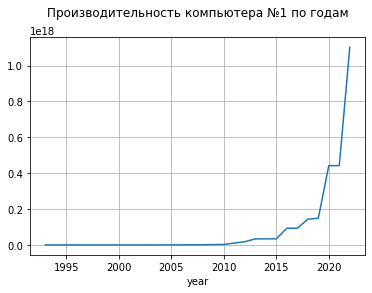

In [183]:
year_perfomance.plot(grid=True, title='Производительность компьютера №1 по годам\n');

Рост явно экспоненциальный, возьмём логарифм:

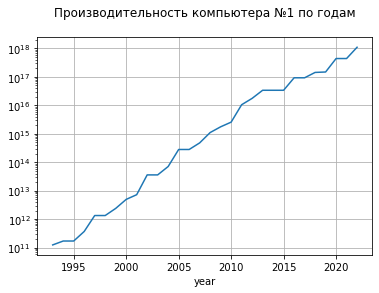

In [184]:
year_perfomance.plot(grid=True, title='Производительность компьютера №1 по годам\n', logy=True);

В 2018 какой-то баг, видимо, неправильная единица измерения - переделаем GFlop в TFlop:

In [76]:
year_perfomance[2018] *= 1_000

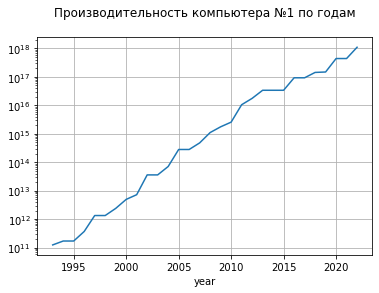

In [185]:
year_perfomance.plot(grid=True, title='Производительность компьютера №1 по годам\n', logy=True);

Тут уже явно наблюдается линейная зависимость

In [180]:
from scipy import stats

res = stats.linregress(year_perfomance.index.values, np.log(year_perfomance).values, )
print('Прогнозная производительность на 2025 год:', round(np.exp(res.intercept + res.slope * 2025) / 1_000_000_000_000_000, 3), 'PFlop/s')

Прогнозная производительность на 2025 год: 11977.725 PFlop/s


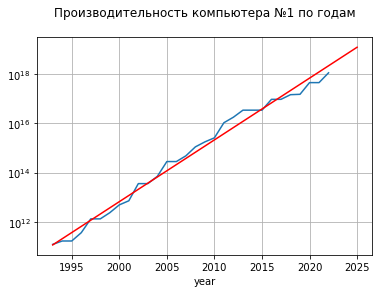

In [186]:
ax = year_perfomance.plot(grid=True, title='Производительность компьютера №1 по годам\n', logy=True)
pd.Series([np.exp(res.intercept + res.slope * year) for year in range(1993, 2026)], index=range(1993, 2026)).plot(grid=True, title='Производительность компьютера №1 по годам\n', logy=True, ax=ax, color='red');

или без логарифма:

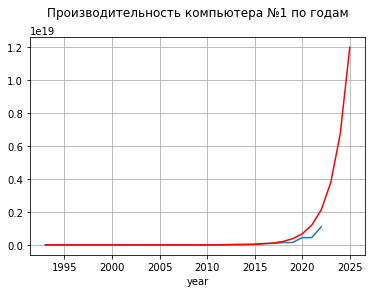

In [187]:
ax = year_perfomance.plot(grid=True, title='Производительность компьютера №1 по годам\n')
pd.Series([np.exp(res.intercept + res.slope * year) for year in range(1993, 2026)], index=range(1993, 2026)).plot(grid=True, title='Производительность компьютера №1 по годам\n', ax=ax, color='red');

Но, скорее всего, прогноз не сбудется и производительность будет меньше, так как видим меньшую скорость, чем экспоненциальную

# Оцените какой процент всего производимого на Земле электричества потребляют все компьютеры из top500 (на основании открытых данных top500.org)

In [188]:
rating = pd.read_html(f'https://top500.org/statistics/sublist/', attrs={'class': 'table table-condensed table-striped'}, header=0)[0]

In [193]:
power = rating.iloc[:, -1].sum() # kW

Нагуглил, что всего производится около 20_000_000_000 kw в год

In [199]:
print('Процент электричества, которое потребляют все компьютеры из top500', round(power / 20_000_000_000 * 100, 5), '%')

Процент электричества, которое потребляют все компьютеры из top500 0.00174 %


# Улучшить производительность программы с реализацией алгоритма матричного умножения 

Можем наблюдать, что действительно порядок решает. kij - самый быстрый вариант.

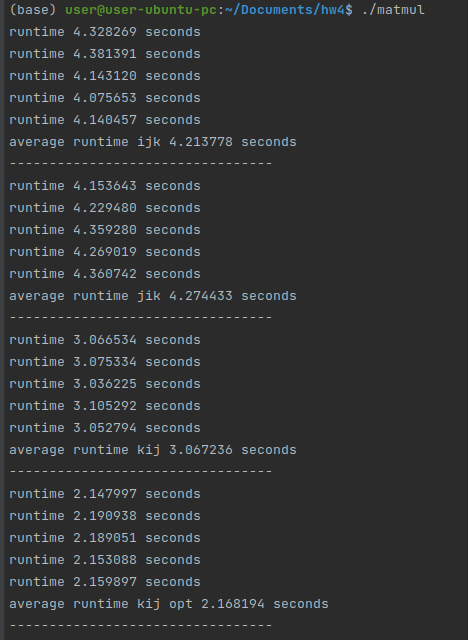

Вычисление значений элементов массивов можно упростить — вынести постоянную часть из внутреннего цикла (-0.5-0.8 секунды)

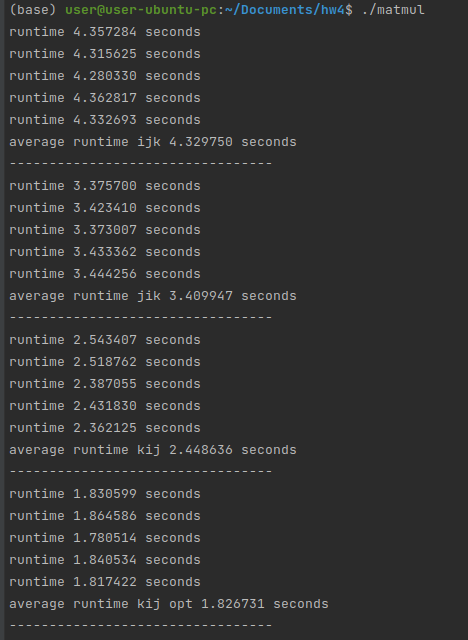

И меняем порядок вычисления таким образом, чтобы внутренним циклом был последовательный обход по строчкам для всех трех матриц

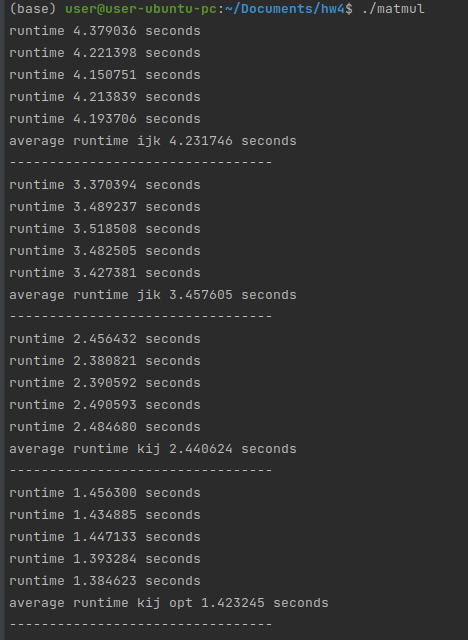

Наибольшее ускорение можно получить с помощью AVX2/FMA (хотя мб уже оптимизировано автоматически) и блочный алгоритмов (микроядер) для уменьшения кэш-промахов